In [1]:
import os as os
import numpy as np
import pandas as pd
from scipy import stats

## Import file of KOs, associated categories, and normalized read counts

In [2]:
os.chdir('/Users/npatin3/Dropbox (GaTech)/Norovirus/Annotation/kofamscan/Assemblies/Asymp_vs_symp')
path = "Asymp_vs_symp_KOs_readcounts.csv"

In [3]:
kos = pd.read_csv(path, header=0)
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism [PATH:ko00051],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism [PATH:ko00052],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism [PATH:ko00500],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism [P...,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [4]:
# Split out the "PATH" part of Subgroup2 label
kos[['Subgroup2', 'PATH']] = kos['Subgroup2'].str.split("[", n=1, expand=True)
kos = kos.drop('PATH', axis=1)
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [5]:
# Exclude irrelevant categories that are not relevant
kos2 = kos.loc[(kos['Group'] != 'Human Diseases') & 
               (kos['Group'] != 'Brite Hierarchies') & 
               (kos['Group'] != 'Organismal Systems') &
               (kos['Subgroup'] != 'Cellular community - eukaryotes')]

In [6]:
kos.size

235930

In [7]:
kos2.size

146530

## Pull out only level of interest, ie KOs or Subgroups2

In [8]:
df = kos2[['KO','Sample','ReadCounts_Norm', 'dataset']]
df.head()

,KO,Sample,ReadCounts_Norm,dataset
0,K00844,13_1,0.001825,Asymptomatic
1,K00844,13_1,0.001825,Asymptomatic
2,K00844,13_1,0.001825,Asymptomatic
3,K00844,13_1,0.001825,Asymptomatic
4,K00844,13_1,0.001825,Asymptomatic


### For KOs only, drop duplicates within each sample

In [9]:
df2 = df.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df2.head()

,KO,Sample,ReadCounts_Norm,dataset
8696,K07720,28_1,0.001192,Asymptomatic
17769,K00791,4_1,0.001192,Symptomatic
17745,K03526,15_1,0.001192,Symptomatic
17742,K00919,4_1,0.001192,Symptomatic
17739,K00919,15_1,0.001192,Symptomatic


## Run t-tests and fold-difference calculations on KOs or categories

#### Reformat data frame

In [10]:
df3 = pd.pivot_table(data=df, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3 = df3.reindex(['4_1','15_1','36_1','37_1','13_1','28_1','38_1','41_1','49_1']).fillna(0)
df3.head()

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.0,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.0,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.0,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.0,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.0,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000


### T-test on each gene between asymptomatic and symptomatic groups

#### Add new empty rows for statistical results

In [11]:
df4 = df3.append(pd.Series(name='ttest'))
df4 = df4.append(pd.Series(name='p-value'))
df4 = df4.append(pd.Series(name='fold difference'))
df4

/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.000000,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.000000,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.000000,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.000000,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.000000,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000
28_1,0.000000,0.001192,0.000000,0.002384,0.000000,0.000000,0.009535,0.000000,0.000000,0.000000,...,0.001192,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.002384
38_1,0.004386,0.006579,0.000000,0.000000,0.000000,0.017544,0.004386,0.000000,0.000000,0.004386,...,0.000000,0.002193,0.000000,0.000000,0.000000,0.000000,0.002193,0.000000,0.000000,0.004386
41_1,0.004373,0.000000,0.000000,0.001458,0.001458,0.013120,0.017493,0.011662,0.000000,0.002915,...,0.000000,0.001458,0.001458,0.000000,0.001458,0.002915,0.008746,0.000000,0.001458,0.002915
49_1,0.003082,0.000000,0.000000,0.000000,0.000000,0.009245,0.004622,0.004622,0.001541,0.010786,...,0.000000,0.006163,0.000000,0.000000,0.000000,0.006163,0.001541,0.000000,0.000000,0.000000


#### Fill new rows with results of scipy stats ttest

In [12]:
df4.iloc[9] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=False))[0]
df4.iloc[10] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=False))[1]
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.000000,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.000000,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.000000,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.000000,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.000000,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000
28_1,0.000000,0.001192,0.000000,0.002384,0.000000,0.000000,0.009535,0.000000,0.000000,0.000000,...,0.001192,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.002384
38_1,0.004386,0.006579,0.000000,0.000000,0.000000,0.017544,0.004386,0.000000,0.000000,0.004386,...,0.000000,0.002193,0.000000,0.000000,0.000000,0.000000,0.002193,0.000000,0.000000,0.004386
41_1,0.004373,0.000000,0.000000,0.001458,0.001458,0.013120,0.017493,0.011662,0.000000,0.002915,...,0.000000,0.001458,0.001458,0.000000,0.001458,0.002915,0.008746,0.000000,0.001458,0.002915
49_1,0.003082,0.000000,0.000000,0.000000,0.000000,0.009245,0.004622,0.004622,0.001541,0.010786,...,0.000000,0.006163,0.000000,0.000000,0.000000,0.006163,0.001541,0.000000,0.000000,0.000000


### Function to calculate fold difference between asymptomatic and symptomatic samples

In [13]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

### Apply function to data frame to calculate fold difference of each column

In [14]:
df4 = df4.replace(0, 0.000000001)
df4.loc['fold difference'] = fold_difference(df4, 4, 9)
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,5.282129e-03,3.649635e-03,1.457726e-02,1.000000e-09,2.372897e-03,...,1.000000e-09,1.641272e-03,1.000000e-09,5.830904e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.622496e-03,1.000000e-09
15_1,4.390448e-03,1.000000e-09,3.333174e-03,4.385965e-03,1.392831e-02,7.541524e-03,2.192982e-03,3.081664e-03,1.327726e-02,5.016962e-03,...,1.000000e-09,1.641272e-03,3.282543e-03,9.124088e-03,3.081664e-03,1.000000e-09,4.385965e-03,1.000000e-09,3.575685e-03,3.081664e-03
36_1,7.980008e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,7.162877e-03,3.081664e-03,2.383790e-03,1.327726e-02,5.498608e-03,...,1.000000e-09,3.040111e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.457726e-03,1.824818e-03,1.000000e-09,4.767580e-03
37_1,9.613080e-03,1.641272e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.042022e-03,3.575685e-03,3.649635e-03,1.000000e-09,2.854544e-03,...,1.000000e-09,3.223657e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.385965e-03,1.540832e-03,1.824818e-03,4.767580e-03
13_1,1.824818e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.474453e-03,1.824818e-02,1.000000e-09,7.299270e-03,1.000000e-09,3.649635e-03,...,1.000000e-09,3.649635e-03,3.649635e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.000000e-09
28_1,1.000000e-09,1.191895e-03,1.000000e-09,2.383790e-03,1.000000e-09,1.000000e-09,9.535161e-03,1.000000e-09,1.000000e-09,1.000000e-09,...,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,2.383790e-03
38_1,4.385965e-03,6.578947e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.754386e-02,4.385965e-03,1.000000e-09,1.000000e-09,4.385965e-03,...,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,4.385965e-03
41_1,4.373178e-03,1.000000e-09,1.000000e-09,1.457726e-03,1.457726e-03,1.311953e-02,1.749271e-02,1.166181e-02,1.000000e-09,2.915452e-03,...,1.000000e-09,1.457726e-03,1.457726e-03,1.000000e-09,1.457726e-03,2.915452e-03,8.746356e-03,1.000000e-09,1.457726e-03,2.915452e-03
49_1,3.081664e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,9.244992e-03,4.622496e-03,4.622496e-03,1.540832e-03,1.078582e-02,...,1.000000e-09,6.163328e-03,1.000000e-09,1.000000e-09,1.000000e-09,6.163328e-03,1.540832e-03,1.000000e-09,1.000000e-09,1.000000e-09


### Select columns where p-value row (row 10) is less than 0.02

In [15]:
kos_significant = df4.loc[:, df4.iloc[10] < 0.02]
kos_significant

KO,K00036,K00145,K00297,K00343,K00549,K00656,K00705,K00757,K00761,K00806,...,K15633,K15771,K15923,K16363,K17319,K17320,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.001541,0.010965,0.002963,1.000000e-09,0.007023,8.085065e-02,0.001541,1.184535e-02,7.288630e-03,0.028509,...,0.006788,1.232666e-02,0.009245,3.994073e-03,1.642336e-02,1.232666e-02,0.003650,1.341663e-02,0.009124,0.005121
15_1,0.001867,0.010727,0.001508,1.000000e-09,0.007023,1.005595e-01,0.009124,1.724651e-02,1.457726e-02,0.027414,...,0.006306,1.642336e-02,0.020073,1.000000e-09,1.315789e-02,1.642336e-02,0.004386,2.206008e-02,0.007299,0.009120
36_1,0.001867,0.010949,0.004557,1.540832e-03,0.010217,5.893994e-02,0.004373,1.205026e-02,1.535088e-02,0.023723,...,0.002683,2.623907e-02,0.007289,1.000000e-09,1.232666e-02,2.623907e-02,0.003082,1.933085e-02,0.002915,0.005601
37_1,0.001867,0.007289,0.005837,1.540832e-03,0.005578,4.283672e-02,0.006579,1.063244e-02,7.704160e-03,0.036443,...,0.003287,1.315789e-02,0.008772,1.692439e-03,8.343266e-03,1.315789e-02,0.001825,1.472745e-02,0.006579,0.004695
13_1,0.007299,0.003650,0.010949,9.124088e-03,0.003650,1.459854e-02,0.010949,1.000000e-09,1.000000e-09,0.001825,...,0.012774,1.000000e-09,0.031022,3.649635e-03,3.649635e-03,3.649635e-03,0.023723,1.000000e-09,0.016423,0.009124
28_1,0.002384,0.001192,0.007151,1.072706e-02,0.003576,1.000000e-09,0.020262,2.383790e-03,1.000000e-09,0.002384,...,0.015495,1.000000e-09,0.036949,9.535161e-03,1.000000e-09,1.000000e-09,0.011919,1.000000e-09,0.028605,0.013111
38_1,0.006579,0.008772,0.006579,8.771930e-03,0.002193,2.412281e-02,0.015351,2.192982e-03,1.000000e-09,0.006579,...,0.006579,1.000000e-09,0.076754,1.315789e-02,2.192982e-03,1.000000e-09,0.017544,4.385965e-03,0.019737,0.026316
41_1,0.008746,0.005831,0.014577,2.915452e-03,0.002915,1.020408e-02,0.018950,5.830904e-03,1.000000e-09,0.007289,...,0.020408,1.000000e-09,0.061224,1.166181e-02,5.830904e-03,1.000000e-09,0.018950,1.457726e-03,0.026239,0.018950
49_1,0.006163,0.003082,0.015408,1.078582e-02,0.003082,1.232666e-02,0.009245,7.704160e-03,1.000000e-09,0.003082,...,0.015408,1.000000e-09,0.035439,4.622496e-03,1.540832e-03,6.163328e-03,0.010786,1.000000e-09,0.010786,0.016949


In [17]:
kos_significant.to_csv("sig_diff_KOs.csv")

### Make list of significant KOs

In [16]:
ko_list = list(kos_significant)

In [17]:
ko_list

['K00036',
 'K00145',
 'K00297',
 'K00343',
 'K00549',
 'K00656',
 'K00705',
 'K00757',
 'K00761',
 'K00806',
 'K00817',
 'K00821',
 'K00847',
 'K00876',
 'K00925',
 'K00963',
 'K00975',
 'K01091',
 'K01133',
 'K01151',
 'K01181',
 'K01190',
 'K01207',
 'K01223',
 'K01270',
 'K01338',
 'K01358',
 'K01480',
 'K01580',
 'K01585',
 'K01591',
 'K01652',
 'K01676',
 'K01677',
 'K01738',
 'K01740',
 'K01776',
 'K01785',
 'K01803',
 'K01809',
 'K01811',
 'K01815',
 'K01868',
 'K01872',
 'K01874',
 'K01892',
 'K01897',
 'K01915',
 'K01937',
 'K01939',
 'K01995',
 'K01998',
 'K02005',
 'K02031',
 'K02038',
 'K02227',
 'K02314',
 'K02316',
 'K02871',
 'K02959',
 'K02996',
 'K03328',
 'K03517',
 'K03531',
 'K03612',
 'K03628',
 'K03654',
 'K03657',
 'K03701',
 'K03702',
 'K03703',
 'K03763',
 'K03783',
 'K03787',
 'K04066',
 'K04079',
 'K04487',
 'K04517',
 'K04564',
 'K04720',
 'K05349',
 'K05515',
 'K05970',
 'K06217',
 'K06400',
 'K06881',
 'K06959',
 'K07017',
 'K07085',
 'K07088',
 'K07133',

### Extract rows from original data frame containing any of the significant KOs

In [18]:
mask = kos2['KO'].apply(lambda x: any(item for item in ko_list if item in x))
df = kos2[mask]

In [19]:
df.shape

(1666, 10)

In [20]:
df.sort_values(by=['KO'])

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
909,Metabolism,Metabolism of other amino acids,Glutathione metabolism,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",3,38_1,456,0.006579,Asymptomatic
902,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",4,13_1,548,0.007299,Asymptomatic
903,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",6,41_1,686,0.008746,Asymptomatic
904,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",3,38_1,456,0.006579,Asymptomatic
905,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",4,49_1,649,0.006163,Asymptomatic
...,...,...,...,...,...,...,...,...,...,...
15561,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,22,15_1,984,0.011662,Symptomatic
15560,Metabolism,Nucleotide metabolism,Purine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,20,4_1,752,0.005474,Symptomatic
15559,Metabolism,Nucleotide metabolism,Purine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,14,37_1,554,0.004768,Symptomatic
3532,Metabolism,Nucleotide metabolism,Purine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,13,41_1,686,0.018950,Asymptomatic


In [21]:
df3 = df.drop_duplicates(subset=['KO'])[['KO','Function']]
df3.head()

,KO,Function
246,K01803,"TPI, tpiA; triosephosphate isomerase (TIM) [E..."
351,K15633,"gpmI; 2,3-bisphosphoglycerate-independent pho..."
625,K01785,"galM, GALM; aldose 1-epimerase [EC:5.1.3.3]"
724,K01223,"E3.2.1.86B, bglA; 6-phospho-beta-glucosidase ..."
867,K01676,"E4.2.1.2A, fumA, fumB; fumarate hydratase, cl..."


In [22]:
df3.shape

(116, 2)

In [231]:
df2.to_csv("KOs_significantly_different_all.csv")

In [35]:
df3.to_csv("KOs_SD_functions.csv")

## Heat map of just the significantly different genes

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/npatin3/miniconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
os.chdir('/Users/npatin3/Dropbox (GaTech)/Norovirus/Annotation/kofamscan/Assemblies/Asymp_vs_symp')

In [25]:
counts = pd.read_csv("Asymp_vs_symp_KOs_readcounts.csv")
counts.head()

In [29]:
df = counts.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
11694,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K04096,smf; DNA processing protein,1,28_1,839,0.001192,Asymptomatic
1921,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K07248,aldA; lactaldehyde dehydrogenase / glycolalde...,1,28_1,839,0.001192,Asymptomatic
1916,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K03778,ldhA; D-lactate dehydrogenase [EC:1.1.1.28],1,28_1,839,0.001192,Asymptomatic
11684,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07459,ybjD; putative ATP-dependent endonuclease of ...,1,28_1,839,0.001192,Asymptomatic
11672,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07454,K07454; putative restriction endonuclease,1,28_1,839,0.001192,Asymptomatic


In [30]:
mask = df['KO'].apply(lambda x: any(item for item in ko_list if item in x))
#inverted_mask = mask2!=True
df2 = df[mask]

In [31]:
df2 = df2[['KO','Sample','ReadCounts_Norm','dataset']]
df2.head()

### Split data frame by abundance of normalized read counts

In [33]:
df2A = df2[df2.ReadCounts_Norm > 0.05]
df2B = df2[df2.ReadCounts_Norm < 0.05]

In [34]:
df2A.shape

(50, 4)

In [35]:
df2B.shape

(894, 4)

### Format for heat map

In [36]:
df3 = pd.pivot_table(data=df2, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3.fillna(0)
df3.head()

KO,K00036,K00145,K00297,K00343,K00549,K00656,K00705,K00757,K00761,K00806,...,K15633,K15771,K15923,K16363,K17319,K17320,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.007299,0.003650,0.010949,0.009124,0.003650,0.014599,0.010949,0.000000,0.000000,0.001825,...,0.012774,0.000000,0.031022,0.003650,0.003650,0.003650,0.023723,0.000000,0.016423,0.009124
15_1,0.002193,0.010727,0.001825,0.000000,0.011662,0.161808,0.009124,0.017544,0.014577,0.027414,...,0.012327,0.016423,0.020073,0.000000,0.026239,0.016423,0.004386,0.027697,0.007299,0.011662
28_1,0.002384,0.001192,0.007151,0.010727,0.003576,0.000000,0.020262,0.002384,0.000000,0.002384,...,0.015495,0.000000,0.036949,0.009535,0.000000,0.000000,0.011919,0.000000,0.028605,0.013111
36_1,0.002193,0.010949,0.007289,0.001541,0.011662,0.092105,0.004373,0.016949,0.015351,0.023723,...,0.004768,0.026239,0.007289,0.000000,0.013158,0.026239,0.003082,0.027697,0.002915,0.006579
37_1,0.002193,0.007289,0.007289,0.001541,0.008772,0.047766,0.006579,0.020073,0.007704,0.036443,...,0.006579,0.026239,0.008772,0.007289,0.012327,0.026239,0.001825,0.021866,0.006579,0.004768


In [37]:
df3A = pd.pivot_table(data=df2A, index='Sample', values='ReadCounts_Norm', columns='KO')
df3A = df3A.fillna(0)
df3A.head()

KO,K00656,K00925,K00975,K01190,K01207,K01811,K02316,K03612,K03701,K04720,K05349,K05970,K06400,K07085,K07133,K07165,K15923
Sample,,,,,,,,,,,,,,,,,
13_1,0.000000,0.000000,0.000000,0.173358,0.000000,0.0,0.0,0.000000,0.05292,0.000000,0.178832,0.05292,0.000000,0.062044,0.000000,0.072993,0.0
15_1,0.161808,0.092105,0.192982,0.000000,0.178832,0.0,0.0,0.000000,0.00000,0.078717,0.000000,0.00000,0.507299,0.000000,0.000000,0.000000,0.0
28_1,0.000000,0.000000,0.000000,0.123957,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.053635,0.000000,0.0
36_1,0.092105,0.161808,0.173358,0.000000,0.178832,0.0,0.0,0.071429,0.00000,0.054825,0.000000,0.00000,0.800292,0.000000,0.000000,0.000000,0.0
37_1,0.000000,0.161808,0.275510,0.000000,0.151316,0.0,0.0,0.054825,0.00000,0.000000,0.000000,0.00000,0.625000,0.000000,0.000000,0.000000,0.0


In [38]:
df3B = pd.pivot_table(data=df2B, index='Sample', values='ReadCounts_Norm', columns='KO')
df3B = df3B.fillna(0)
df3B.head()

KO,K00036,K00145,K00297,K00343,K00549,K00656,K00705,K00757,K00761,K00806,...,K15633,K15771,K15923,K16363,K17319,K17320,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.007299,0.003650,0.010949,0.009124,0.003650,0.014599,0.010949,0.000000,0.000000,0.001825,...,0.012774,0.000000,0.031022,0.003650,0.003650,0.003650,0.023723,0.000000,0.016423,0.009124
15_1,0.002193,0.010727,0.001825,0.000000,0.011662,0.000000,0.009124,0.017544,0.014577,0.027414,...,0.012327,0.016423,0.020073,0.000000,0.026239,0.016423,0.004386,0.027697,0.007299,0.011662
28_1,0.002384,0.001192,0.007151,0.010727,0.003576,0.000000,0.020262,0.002384,0.000000,0.002384,...,0.015495,0.000000,0.036949,0.009535,0.000000,0.000000,0.011919,0.000000,0.028605,0.013111
36_1,0.002193,0.010949,0.007289,0.001541,0.011662,0.000000,0.004373,0.016949,0.015351,0.023723,...,0.004768,0.026239,0.007289,0.000000,0.013158,0.026239,0.003082,0.027697,0.002915,0.006579
37_1,0.002193,0.007289,0.007289,0.001541,0.008772,0.047766,0.006579,0.020073,0.007704,0.036443,...,0.006579,0.026239,0.008772,0.007289,0.012327,0.026239,0.001825,0.021866,0.006579,0.004768


In [39]:
# Log transform
df3_log = np.log(df3.replace(0, 0.0000001))
df3_log.head()

KO,K00036,K00145,K00297,K00343,K00549,K00656,K00705,K00757,K00761,K00806,...,K15633,K15771,K15923,K16363,K17319,K17320,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,-4.919981,-5.613128,-4.514516,-4.696837,-5.613128,-4.226834,-4.514516,-16.118096,-16.118096,-6.306275,...,-4.360365,-16.118096,-3.473062,-5.613128,-5.613128,-5.613128,-3.741326,-16.118096,-4.109051,-4.696837
15_1,-6.122493,-4.534986,-6.306275,-16.118096,-4.451436,-1.821347,-4.696837,-4.043051,-4.228293,-3.596716,...,-4.395991,-4.109051,-3.908380,-16.118096,-3.640506,-4.109051,-5.429346,-3.586439,-4.919981,-4.451436
28_1,-6.039064,-6.732211,-4.940451,-4.534986,-5.633598,-16.118096,-3.898997,-6.039064,-16.118096,-6.039064,...,-4.167261,-16.118096,-3.298224,-4.652769,-16.118096,-16.118096,-4.429626,-16.118096,-3.554157,-4.334315
36_1,-6.122493,-4.514516,-4.921440,-6.475433,-4.451436,-2.384823,-5.432265,-4.077537,-4.176583,-3.741326,...,-5.345916,-3.640506,-4.921440,-16.118096,-4.330733,-3.640506,-5.782286,-3.586439,-5.837730,-5.023881
37_1,-6.122493,-4.921440,-4.921440,-6.475433,-4.736198,-3.041446,-5.023881,-3.908380,-4.865995,-3.312002,...,-5.023881,-3.640506,-4.736198,-4.921440,-4.395991,-3.640506,-6.306275,-3.822827,-5.023881,-5.345916


In [40]:
# Square root transform
df3_sqrt = np.sqrt(df3.replace(0, 0.0000001))
df3_sqrt.head()

KO,K00036,K00145,K00297,K00343,K00549,K00656,K00705,K00757,K00761,K00806,...,K15633,K15771,K15923,K16363,K17319,K17320,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.085436,0.060412,0.104637,0.095520,0.060412,0.120824,0.104637,0.000316,0.000316,0.042718,...,0.113021,0.000316,0.176130,0.060412,0.060412,0.060412,0.154022,0.000316,0.128154,0.095520
15_1,0.046829,0.103572,0.042718,0.000316,0.107990,0.402253,0.095520,0.132453,0.120736,0.165570,...,0.111025,0.128154,0.141679,0.000316,0.161985,0.128154,0.066227,0.166424,0.085436,0.107990
28_1,0.048824,0.034524,0.084566,0.103572,0.059797,0.000316,0.142345,0.048824,0.000316,0.048824,...,0.124477,0.000316,0.192221,0.097648,0.000316,0.000316,0.109174,0.000316,0.169132,0.114503
36_1,0.046829,0.104637,0.085373,0.039253,0.107990,0.303488,0.066130,0.130189,0.123899,0.154022,...,0.069048,0.161985,0.085373,0.000316,0.114708,0.161985,0.055513,0.166424,0.053995,0.081111
37_1,0.046829,0.085373,0.085373,0.039253,0.093659,0.218554,0.081111,0.141679,0.087773,0.190901,...,0.081111,0.161985,0.093659,0.085373,0.111025,0.161985,0.042718,0.147871,0.081111,0.069048


## Set palette for color bar

In [46]:
my_palette = dict(zip(df2.dataset.unique(), ["purple","orange"]))
row_colors = df.dataset.map(my_palette)
sampz = df.Sample

In [47]:
sample_colors = sampz.to_frame().join(row_colors)
sample_colors = sample_colors.drop_duplicates(subset=['Sample'])
sample_colors = sample_colors.set_index('Sample')
sample_colors.head()

,dataset
Sample,
28_1,purple
15_1,orange
37_1,orange
4_1,orange
36_1,orange


## Make the heatmap

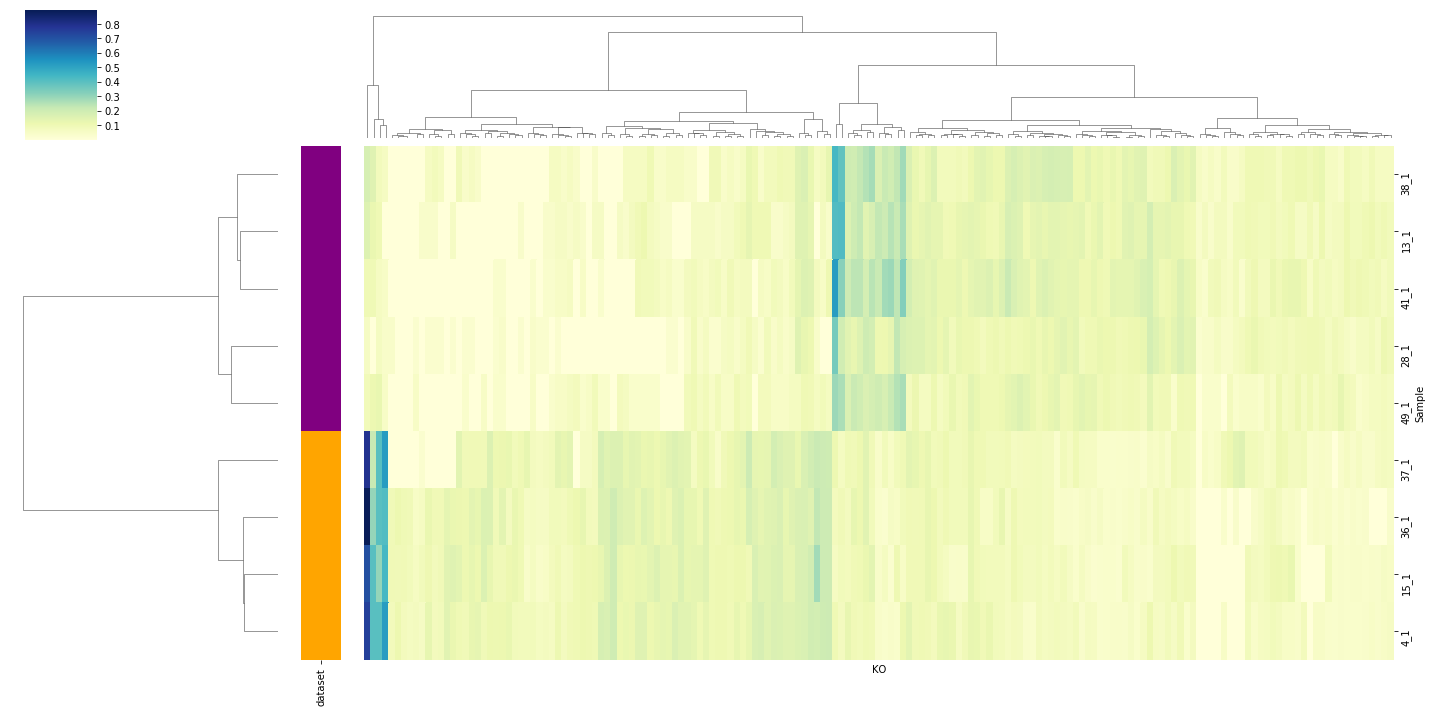

In [127]:
p = sns.clustermap(df3_log, cmap='YlGnBu', figsize=(20,10), xticklabels=False, method='ward', metric='euclidean', row_colors = sample_colors)

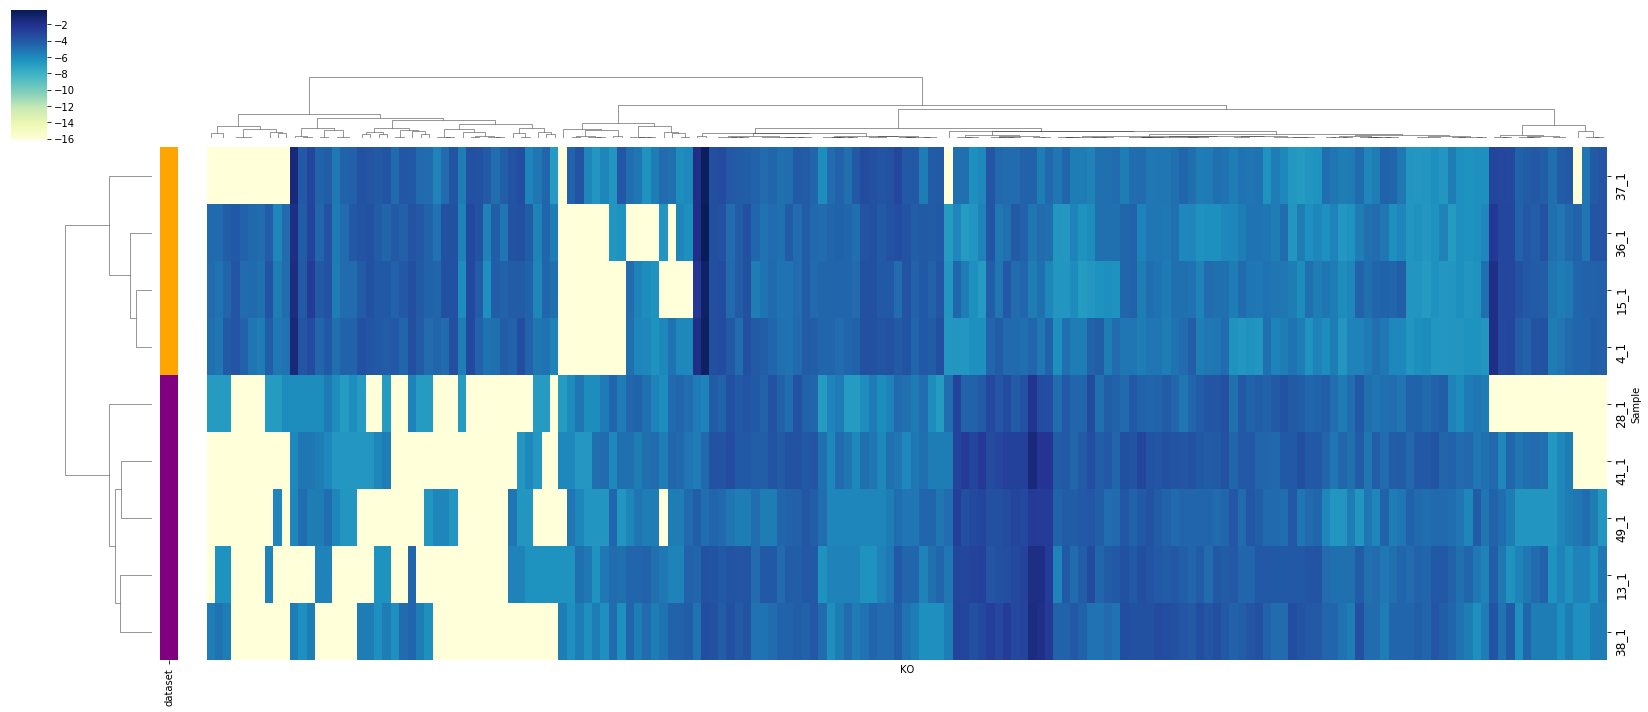

In [130]:
p = sns.clustermap(df3_log, cmap='YlGnBu', method='ward', metric='euclidean', xticklabels=False, row_colors = sample_colors)
hm = p.ax_heatmap.get_position()
plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)
plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), fontsize=18)
p.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*3, hm.height])
col = p.ax_col_dendrogram.get_position()
row = p.ax_row_dendrogram.get_position()
p.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*3, col.height*0.5])
p.ax_row_dendrogram.set_position([row.x0+0.07, row.y0, row.width*0.75, row.height])

In [131]:
p.savefig("All_SD_KOs_log.png")